# QuTiP Lecture: Particle emission from a photon cascade

D. Lukin, Stanford University

In this Jupyter notebook, we use QuTiP: The Quantum Toolbox in Python to study a cascaded three level system excited by a classical pulse. This model system captures the essense of the dynamics of a biexcitonic in a quantum dot [[1,2]](#refs).

For more information about QuTiP see the project web page: http://qutip.org/

## Introduction

The system consists of three states: ground $\left|g\right\rangle$, intermediate $\left|i\right\rangle$, and excited $\left|e\right\rangle$. The process we are modeling is the two-photon excitation of the system with a classical pulse driving the transition $\left|g\right\rangle \to  \left|e\right\rangle$. The system is coupled to two decay channels, via collapse operators 
 $\sigma_1 = \sqrt{\gamma_1} \left|i\right\rangle \left\langle e\right| $ and $\sigma_2 = \sqrt{\gamma_2} \left|g\right\rangle \left\langle i\right| $. Here, $\gamma_1$ and $\gamma_2$ are the coupling strength of the system to channels 1 and 2. In all simulations, we are setting $2\gamma_2 = \gamma_1 = \gamma$.
 
In a frame rotating at the laser's frequency for the two-photon resonance, the system Hamiltonian is given by 

$$H_{\mbox{sys}} = H_0 + H_E(t)$$

where $$H_0 = E_b/2 \left|i\right\rangle \left\langle i\right|$$ 

and $H_E$ represents two-photon excitation of the system by a classical pulse in the rotating wave appoximation. Further,

$$H_I(t) =  \frac{(\mu \cdot E(t))^2}{E_b} (\left|g\right\rangle \left\langle e\right| + \left|e\right\rangle \left\langle g\right|) .$$

Here, $E(t)$ is the time dependent electric field pulse driving the system, $\mu$ is the coupling strength, and $E_b$ is the binding energy of the biexciton. The driving strength depends on the square of $\mu \cdot E(t)$ because the coherent drive occurs via virtual excitation of the intermediate state.

The system-only evolution (tracing over the dynamics of the two channels into which the system spontaneously emits), is given by the Master Equation:
\begin{equation}
\partial_t \rho = \mathcal L\rho = -i[H_I(t), \rho] + \mathcal D[\sigma_1]\rho +  \mathcal D[ \sigma_2]\rho,
\end{equation}
where $\mathcal D[c]\rho = c\rho c^\dagger - \frac 12 (c^\dagger c \rho + \rho c^\dagger c)$ is the standard Lindblad dissipator.

## Setting Up Computation in QuTiP

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

### Setup of time discretization and pulse

In [3]:
# time parameters
gamma = 1.0                         # decay rate, sets the overall timescale of the system
globaldt = 0.15/gamma               # default time step
minpointsperpulse = 5.0             # minimum time resolution of a pulse        

# define function E(t), a gaussian.
def pulse_shape(t, args):
    width = args['width']
    norm = args['norm']

    pulse_t_offset = 3.5
    t_offset = width*pulse_t_offset
    return norm * np.exp(-(t - t_offset) ** 2.0 /
                                  (2.0 * width ** 2.0))

# pulse normalization function
def pulsenormconst(args):
    args['norm'] = 1.0
    tlist = tlistfunc(args)
    unnorm_pulse = [pulse_shape(t, args) for t in tlist]
    unnorm_pulse_area = np.trapz(unnorm_pulse, tlist)
    return 1/unnorm_pulse_area

# in order to speed up the simulation for shorter pulses, we take advantage of 
# QuTiP's built in support for variable time steps. This function generates a 
# the list of times for which system dynamics will be calculated.
def tlistfunc(args):
    width = args['width']
    norm = args['norm']
    tmin = args['tmin']
    tmax = args['tmax']
    
    tlist = []

    pulse_t_offset = 3.5
    
    # if the global time resolution satisfies the minimum number of points per 
    # pulse, make time list a simple linearly-spaced set of points.
    if width/minpointsperpulse > globaldt: 
        tlist = np.linspace(tmin, tmax, int((tmax - tmin)/globaldt))
        
    # otherwise, increase resolution inside the pulse only.
    else:       
        tlist1 = np.linspace(tmin, width*pulse_t_offset*2.0, \
                             int(minpointsperpulse*(pulse_t_offset*2.0 - tmin)))[:-1]
        tlist2 = np.linspace(width*pulse_t_offset*2.0, tmax, \
                             int((tmax - width*pulse_t_offset*2.0)/globaldt))
        tlist = np.append(tlist1, tlist2)
    
    return tlist

def prepare_pulse(width):
    pulseargs = {'width':width * gamma, 'tmin':0.0, 'tmax':width*1.5 + 5.0/gamma} # define pulse properties
    pulseargs['norm'] = pulse_area * pulsenormconst(pulseargs)    # compute numerically the normalization constant
    tlist = tlistfunc(pulseargs)                                  # generate time list 
    pulse = [pulse_shape(t, pulseargs) for t in tlist]            # generate pulse shape
    return tlist, pulse, pulseargs

### Setup of the physics

For this notebook, we consider the case of so-called $\pi$ area pulses, which for short pulses prepare the system in the excited state $|e\rangle$.

In [4]:
C = 1 # includes dipole coupling strength and binding energy

pulse_area = np.pi/(C**2) # setting area of pulse to Pi.

#System state space
g = fock(3,0)
i = fock(3,1)
e = fock(3,2)

# Hamiltonian
H0 = qeye(3)                          # identity because we are in the interaction picture
H_I = C/2 * (e*g.dag() + g*e.dag())  # time dependent field
H = [H0, [H_I, pulse_shape]]          # complete system Hamiltonian

s1 = np.sqrt(2*gamma) * i*e.dag()     # lowering operator for channel 1
s2 = np.sqrt(gamma) * g*i.dag()       # lowering operator for channel 2

## Dynamics of System Expectation Values
We begin by checking that the system is set up correctly by computing the system dynamics given by 
$$
\partial_t \rho = \mathcal L\rho = -i[H_I(t), \rho] + \mathcal D[\sqrt{\gamma_1} \sigma_1]\rho +  \mathcal D[\sqrt{\gamma_2} \sigma_2]\rho,
$$
and extracting the expectation values of projection operators $\Pi_i = \left|i\right\rangle \left\langle i\right|$ and $\Pi_e = \left|e\right\rangle \left\langle e\right|$.

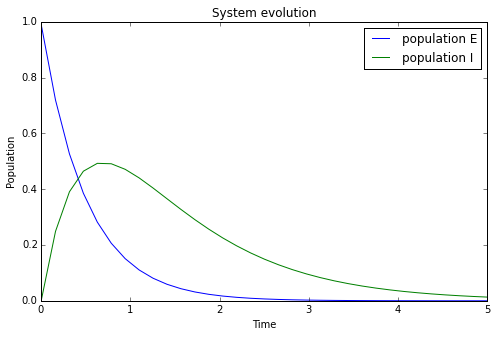

In [5]:
#prepare pulse (argument is pulse width)
tlist, pulse, pulseargs = prepare_pulse(0.001)

#compute system evolution and expectation values of projectors. Supply pulseargs as parameter for H(t).
result = mesolve(H, g, tlist, [s1, s2], [e*e.dag(), i*i.dag()], args=pulseargs)
e_expvals = result.expect[0]
i_expvals = result.expect[1]

#plot the data
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(tlist,e_expvals, label="population E")
ax.plot(tlist,i_expvals, label="population I")
ax.legend()
ax.set_xlabel('Time');
ax.set_ylabel('Population');
ax.set_xlim(0, 5)
ax.set_title('System evolution');

We see that the system behaves correctly: The short pulse dynamics are captured, where the system briefly visits unity excitation of the excite state, indicating that time discretization is properly set up. Note also that the decay rate of $\left|e\right\rangle$ is twice as fast as the decay rate of $\left|i\right\rangle$.

It is straightforward to compute the expectation value for the total number of photons emitted into either channel, since the rate of photon emission is given by $\mbox{Tr}[\rho(t) \sigma_1^\dagger \sigma_1]$ or $\mbox{Tr}[\rho(t) \sigma_2^\dagger \sigma_2]$ and thus 
$$\langle N\rangle = \int_0^\infty\mbox{Tr}[\rho(t) \ \sigma_1^\dagger \sigma_1] \ dt = \gamma_1 \int_0^\infty \langle \Pi_e \rangle \ dt$$

In [6]:
Nexp = 2*gamma*np.trapz(result.expect[0], tlist); print(Nexp)

0.9977906071836861



## Computing N-photon emission probabilities

Using the formalism of conditioned evolution, the $N$-photon emission probability is given by
$$P(N) = \int_0^\infty dt_1 \int_0^\infty dt_2 \dots \int_0^\infty dt_N \ p(t_1, t_2, \dots t_N),$$
where $p(t_1, t_2, \dots t_N)$ is the probability that the system emits photons at only times $\{t_1, t_2, \dots t_N\}$. 

The number of photons emitted into channels 1 and 2 is always equal, because of the cascade nature of the system. We can thus choose to monitor (condition) the emission from either channel, while tracing over the state of the second channel. We choose, arbitrarily, to monitor channel 1.

We define the collapse superoperator for channel $1$ as $\mathcal S\rho = \sigma_1\rho \sigma_1^\dagger$, and the nonunitary evolution conditioned on no emision as $\mathcal K = \mathcal L - \mathcal S$. Then $p(t_1, t_2, \dots t_N)$ is given by
$$p(t_1, t_2, \dots t_N) = \mbox{Tr}[\mathcal K(\infty, t_N) \ \mathcal S \ \mathcal K(t_N, t_{N-1}) \ \mathcal S \ \dots \ \mathcal S \ \mathcal K(t_1, 0)\left| g \right\rangle \left \langle g \right |]$$

This expression for $p(t_1, t_2, \dots t_N)$ is derived in Carmichael, Chapter 7 [[3](#refs)]. Since the final state of the atom is always $\left | g\right \rangle$, the trace takes only a single entry of the density matrix $\left\langle g\right |\rho(t\rightarrow\infty)\left | g \right\rangle$.

Explicitly the superoperator $\mathcal K$ is
$$
\mathcal K\rho = -i[H_I(t), \rho] +\mathcal D[\sqrt{\gamma_2} \sigma_2]\rho - (\sigma_1^\dagger\sigma_1 \rho + \rho \sigma_1^\dagger\sigma_1)/2
$$
We set up $\mathcal K$ in QuTiP as follows:

In [7]:
Ktimedep = -1.0j * C/2 * (spre(e*g.dag() + g*e.dag()) - spost(e*g.dag() + g*e.dag()))
Ktimeindep =  - 0.5 * (spre(s1.dag()*s1) + spost(s1.dag()*s1)) \
              + sprepost(s2, s2.dag()) - 0.5*(spre(s2.dag()*s2) + spost(s2.dag()*s2))

K =  [Ktimeindep, [Ktimedep, pulse_shape]]

To evaluate $p(t_1, t_2, \dots t_N)$, we initialize the system in the ground state $\rho(0) = \left|g\right\rangle \left\langle g \right |$, and evolve it with $\mathcal K$ from $t = 0$ to $t = t_1$. Then we act on the evolved $\rho$ with $\mathcal S$, then evolve with $\mathcal K$ until $t = t_2$, etc.

When computing the total $N$-photon probability $P(N)$, it is possible to re-use solutions from different trajectories to make the algorithm more time-efficient. A natural implementation of this is with recursion.

In [8]:
#parameters
width = 0.05 #pulse width

#prepare pulse
tlist, pulse, pulseargs = prepare_pulse(width)

def conditionalIteration(rhoinit, totalphotons, iternumber, tinitindex):
    '''
    Recursive function that computes the probability of emission of N photons, P(N) 
    rhoinit - initial state of the system
    totalphotons - N
    iternumber - current recursion level
    tinitindex - the index in tlist that determines the timestep from which to begin the recursive computataion
    '''
    curritertrajprobs = []
    curritertimes = []
    if iternumber == totalphotons: 
        out = mesolve(K, rhoinit, tlist[tinitindex:], [], [], args=pulseargs)
        rho = out.states[-1]
        prob = expect(g*g.dag(), rho)
        if totalphotons == 0: #if calculating P(0), the innermost recursion step is also the 
            return prob       #outermost one, so return probability, not probability density.
        else:                 #else return the probability density 
            return tlist[tinitindex], prob
    else:
        conditionedrho = mesolve(K, rhoinit, tlist[tinitindex:], [], [], args=pulseargs)
        for i in range(tinitindex,len(tlist)):
            rho = conditionedrho.states[i - tinitindex]
            rhoprojected = s1 * rho * s1.dag()
            outtime,outtrajprob = conditionalIteration(rhoprojected, totalphotons, iternumber + 1, i)
            curritertrajprobs.append(outtrajprob)
            curritertimes.append(outtime)
        integral = abs(np.trapz(curritertrajprobs, curritertimes))
        if iternumber == 0:
            return integral                    #for the outermost loop, return final cummilative probability.
        else:
            return integral, tlist[tinitindex] #for inner loops return probability density term by term.

#Calculate N-photon probabilities by calling the recursive function
P0 = conditionalIteration(g*g.dag(), 0, 0, 0); print("P(0) = " + str(P0))
P1 = conditionalIteration(g*g.dag(), 1, 0, 0); print("P(1) = " + str(P1))
P2 = conditionalIteration(g*g.dag(), 2, 0, 0); print("P(2) = " + str(P2))

P(0) = 0.002715148979783426
P(1) = 0.9873106987545373
P(2) = 0.0009142280636881267


Thus, we see that for a short pulse, the system acts as a good single photon source. This calculation may require higher time resolution for short pulses to achieve high accuracy. 

## Computing the system+channel density matrix

The results in the section are covered in Ref. [[2]](#refs).

We take a step back and consider a representation of the three-level system coupled to two dissipative channels where no information about the state is discarded. In the coarse-grained time basis [[4]](#refs), the state can be written as

$$\left|\Psi\right\rangle = \sum_{\phi_j, \mathbf T_1, \mathbf T_2} c_{\phi_j, \mathbf T_1, \mathbf T_2} \left|\phi_j, \mathbf T_1, \mathbf T_2\right\rangle,$$
where $\phi_j \in \{g, j, e\}$, $\mathbf T_k = \{t_1, t_2, \cdots, t_N\}$ is the list of times when a photon was emitted into channel $k$.

We may now trace over the second channel, thus obtaining a mixed state:

$$\chi = \mbox{Tr}_{\mathbf T_2}[\left|\Psi\right\rangle \left\langle \Psi \right |] = \sum_{\mathbf T''_2} \sum_{\phi_j, \mathbf T_1, \mathbf T_2} \sum_{\phi_j', \mathbf T_1', \mathbf T_2'} c_{\phi_j, \mathbf T_1, \mathbf T_2} c^*_{\phi'_j, \mathbf T_1', \mathbf T_2'}\langle \mathbf T_2''  \left|\phi_j, \mathbf T_1, \mathbf T_2\right\rangle \langle \phi'_j, \mathbf T'_1, \mathbf T'_2  \left|\mathbf T''_2\right\rangle.$$

The modes of channel 2 are orthogonal, thus,


$$\chi = \sum_{\mathbf T_2} \sum_{\phi_j, \mathbf T_1} \sum_{\phi_j', \mathbf T_1'} c_{\phi_j, \mathbf T_1, \mathbf T_2} c^*_{\phi'_j, \mathbf T_1', \mathbf T_2}\langle \mathbf T_2  \left|\phi_j, \mathbf T_1, \mathbf T_2\right\rangle \langle \phi'_j, \mathbf T'_1, \mathbf T_2  \left|\mathbf T_2\right\rangle.$$

We can re-define the states in the Hilbert space of system and channel 1 only, and write:

$$\chi = \sum_{\phi_j, \mathbf T_1} \sum_{\phi_j', \mathbf T_1'} \Big(\sum_{\mathbf T_2} c_{\phi_j, \mathbf T_1, \mathbf T_2} c^*_{\phi'_j, \mathbf T_1', \mathbf T_2}\Big) \left|\phi_j, \mathbf T_1\right\rangle\left\langle\phi'_j, \mathbf T'_1\right|$$

We see that 
$$\sum_{\mathbf T_2} c_{\phi_j, \mathbf T_1, \mathbf T_2} c^*_{\phi'_i, \mathbf T_1', \mathbf T_2} = \left\langle\phi'_i, \mathbf T'_1\right|\chi\left|\phi_j, \mathbf T_1\right\rangle$$ is the matrix element of the reduced density matrix of the system and channel 1 only. Note that since the initial state and final state of the system is $\left | g\right\rangle$, only elements $\phi_j = \phi_j' = g$ are nonzero. We can thus drop the system state labels and denote the matrix elements by $\left\langle\mathbf T'_1\right|\chi\left| \mathbf T_1\right\rangle $.

It turns out, in the process of obtaining $P(N)$ in the previous section, we already computed the diagonal elements of $\chi$. 


Calculation of the off-diagonal elements was made possible with the technique in Ref. [[4]](#refs) and was derived in Ref. [[2]](#refs). We present the final result:

$$
\left\langle\mathbf{T'}_1\big|\ \chi \ \big|\mathbf{T}_1\right\rangle =  \text{Tr}_\text{sys}\big[\mathcal{K}(\infty, \tau_N)\mathcal S_{Q[\tau_N]}\mathcal{K}(\tau_N, \tau_{N-1})\mathcal S_{Q[\tau_{N-1}]}\cdots \mathcal{K}(\tau_2,\tau_1)\mathcal S_{Q[\tau_1]} \mathcal{K}(\tau_1,0)\left | g\right\rangle\left\langle g\right |\big]
$$

Here, ${\tau_i}$ is a time ordered set of times $\mathbf T_1 \cup \mathbf T_1'$, $\mathcal K$ is defined as before, and $Q[\tau_{i}]$ takes on the value 1 if $\tau_i \in \mathbf T_1$, and 0 if $\tau_i \in \mathbf T_1'$. The operators
$\mathcal S_0, \mathcal S_1$ are defined as $$\mathcal S_0\rho = \sigma_1 \rho$$ $$\mathcal S_1\rho = \rho\sigma_1$$

Note, this calculation is very similar to 
$$p(t_1, t_2, \dots t_N) = \mbox{Tr}[\mathcal K(\infty, t_N) \ \mathcal S \ \mathcal K(t_N, t_{N-1}) \ \mathcal S \ \cdots \ \mathcal S \ \mathcal K(t_1, 0)\left| g \right\rangle \left \langle g \right |].$$

The difference is that instead of applying the collapse operator on both sides for a given emission time $t$, one has to apply them either on the right or the left, depending on whether $\tau$ comes from $\mathbf T_1$ or $\mathbf T_1'$.

Computing the full density matrix for a large number of photon emissions is computationally expensive. Here, we will only calculate the density matrix for 1-photon channel states:


In [9]:
#parameters
width = 0.05 #pulse width

#prepare pulse
tlist, pulse, pulseargs = prepare_pulse(width)

#array to be populated with terms of the system-channel density matrix
rhototal = [[0 for x in tlist] for x in tlist]  

result = mesolve(K, g*g.dag(), tlist, [], [], args=pulseargs)
rho_pre_emission = result.states

#since rhototal is Hermitian, it is sufficient to calculate only terms on the diagonal and above. 
#tL (tR) represents the emission time on the left, a.k.a in T1 (right, a.k.a in T1'). 
for tL in range(len(tlist)):
    result = mesolve(K, s1 * rho_pre_emission[tL], tlist[tL:], [], [], args=pulseargs)
    rho_post_tL = result.states
    for tR in range(tL,len(tlist)):
        i = tR - tL
        result = mesolve(K, rho_post_tL[i] * s1.dag(), tlist[tR:], [], [], args=pulseargs)
        rhofinal = result.states[-1]
        matelement = expect(g*g.dag(), rhofinal)
        rhototal[tR][tL] = np.conjugate(matelement)
        rhototal[tL][tR] = matelement

Having obtained the entire system+channel density matrix, we can compute quantities that previously were not accessible to us. For instance, the trace purity of the single photon emission into channel 1, defined as
$$\mathbb P = \lim_{t\to\infty} \int_0^t \mbox{d}t_1  \int_0^t \mbox{d}t_1' \frac{\bigl|\left\langle t_1'\big| \ \chi \ \big| \ t_1 \right\rangle \bigr|^2}{P(1)^2} $$

So let's compute the one-photon-purity:

In [10]:
diagonal = np.diagonal(rhototal)
P1 = np.trapz(diagonal, tlist) 
Purity = np.trapz([np.trapz(np.square(rhototal[row]), tlist) for row in range(len(tlist))] , tlist)/(P1**2)

print("P(1) = "+ str(P1)) #note that this number should agree with P(1) from the previous section
print("Purity = "+ str(Purity))

P(1) = 0.9873106987545373
Purity = 0.6682330028475325


## References

<a id='refs'></a>

[1] Quantum dot single photon sources with ultra-low multi-photon probability, Lukas Hanschke, Kevin A. Fischer, Stefan Appel, Daniil Lukin, Jakob Wierzbowski, Shuo Sun, Rahul Trivedi, Jelena Vučković, Jonathan J. Finley, Kai Müller. (2018) [[arXiv:1801.01672](https://arxiv.org/abs/1801.01672)]

[2] Particle emission from open-quantum systems, Kevin A. Fischer, Rahul Trivedi, Daniil Lukin. (2017) [[arXiv:1803.04648](https://arxiv.org/abs/1803.04648)]

[3] H. Carmichael, An Open Systems Approach to Quantum Optics, Lectures Presented at the Université Libre de Bruxelles, 1991

[4] Scattering of Coherent Pulses from Quantum-Optical Systems, Kevin A. Fischer, Rahul Trivedi, Vinay Ramasesh, Irfan Siddiqi, Jelena Vučković. (2017) [[arXiv:1710.02875](https://arxiv.org/abs/1710.02875)]

## Version

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+36fd841
Numpy,1.14.1
SciPy,0.18.1
matplotlib,1.4.3
Cython,0.24.1
Number of CPUs,8
BLAS Info,OPENBLAS
IPython,4.2.0
Python,"3.4.3 (default, Nov 28 2017, 16:41:13) [GCC 4.8.4]"
OS,posix [linux]
